In [136]:
import sys
module_root = '..'
if module_root not in sys.path:
  sys.path.insert(0, module_root)
import os
graphviz_bin_dir = f'{os.environ["HOME"]}/.nix-profile/bin/'
if graphviz_bin_dir not in os.environ['PATH'].split(os.pathsep):
  os.environ['PATH'] += os.pathsep + graphviz_bin_dir
from numpy import r_, zeros_like, atleast_2d, array, concatenate
from numpy.typing import NDArray
from typing import List, Generator, Iterable, NamedTuple, Optional, Any, Dict
from graphviz import Digraph
from importlib import reload
import minigrad.tensor as mg_tensor
from IPython.display import display, display_svg, clear_output
import ipywidgets as widgets
from numpy.random import rand

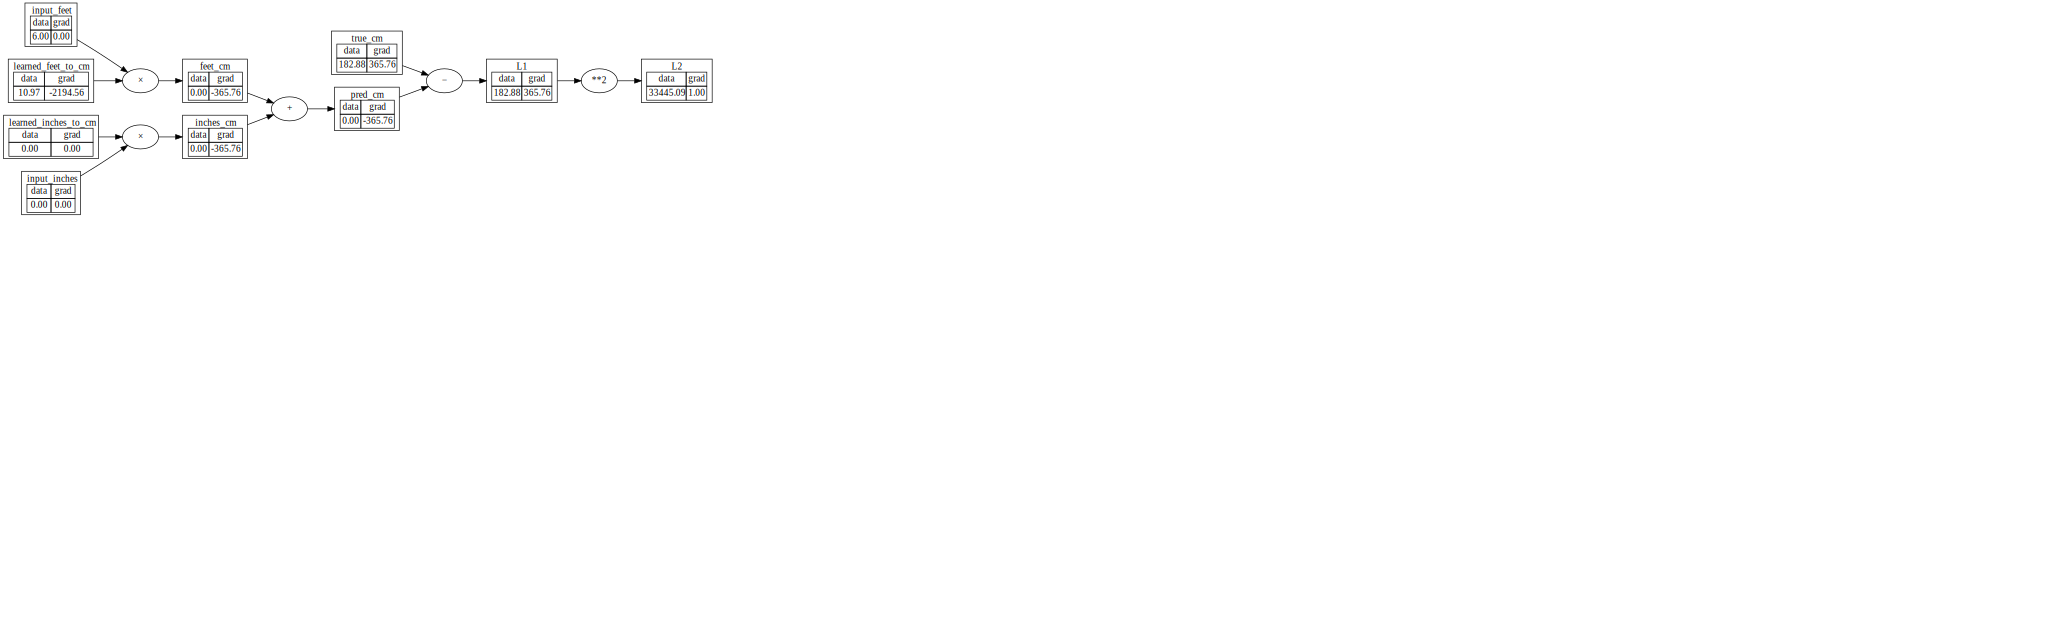

In [137]:
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot, default_graph_attr

def feet_inches() -> Digraph:
  lr = 5e-3
  feet = BadTensor(r_[6.], label='input_feet')
  inches = BadTensor(r_[0.], label='input_inches')
  # should converge on 2.54*12
  feet_to_cm = BadTensor(r_[0.], label='learned_feet_to_cm', train_me=True)
  # should converge on 2.54
  inches_to_cm = BadTensor(r_[0.], label='learned_inches_to_cm', train_me=True)
  expected_cm = BadTensor(r_[182.88], label='true_cm')

  for _ in range(1):
    feet_cm = (feet * feet_to_cm).label_('feet_cm')
    inches_cm = (inches * inches_to_cm).label_('inches_cm')
    predicted_cm = (feet_cm + inches_cm).label_('pred_cm')
    L1 = (expected_cm - predicted_cm).label_('L1')
    L2 = (L1 ** 2).label_('L2')
    
    for t in L2.ancestors():
      t.grad = zeros_like(t.data)

    L2.backward()

    trainable: List[BadTensor] = [t for t in L2.ancestors() if t.train_me]
    for t in trainable:
      t.data -= t.grad * lr

  return draw_dot(L2, graph_attr={**default_graph_attr, 'size': '40,40!', 'dpi': '25' })
feet_inches()

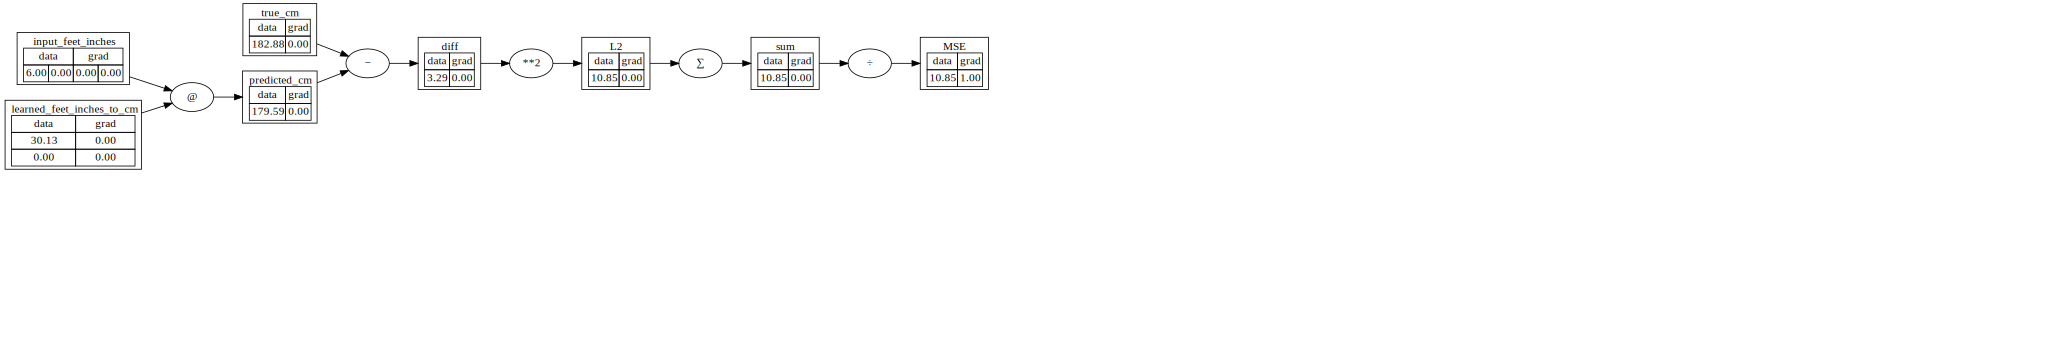

In [138]:
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot

def feet_inches_mat() -> Digraph:
  lr = 5e-3
  feet_inches = BadTensor(atleast_2d([6., 0.]), label='input_feet_inches')
  # print(feet_inches.data)
  # should converge on [[2.54*12], [2.54]]
  feet_inches_to_cm = BadTensor(atleast_2d([0., 0.]).T, label='learned_feet_inches_to_cm', train_me=True)
  # print(feet_inches_to_cm.data)
  expected_cm = BadTensor(atleast_2d([182.88]), label='true_cm')

  for _ in range(10):
    predicted_cm = (feet_inches @ feet_inches_to_cm).label_('predicted_cm')
    diff = (expected_cm - predicted_cm).label_('diff')
    L2 = (diff ** 2).label_('L2')

    sum = (L2.sum()).label_('sum')
    mse = (sum / L2.data.size).label_('MSE')

    mse.backward()

    trainable: List[BadTensor] = [t for t in mse.ancestors() if t.train_me]
    for t in trainable:
      t.data -= t.grad * lr
    
    for t in mse.ancestors():
      t.grad = zeros_like(t.data)

  return draw_dot(mse, graph_attr={**default_graph_attr, 'size': '40,40!', 'dpi': '35' })
feet_inches_mat()

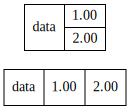

In [139]:
# def join_elems(arr: Iterable[str]) -> str:
#   return '{ %s }' % ('|'.join(arr),)

# def make_label(data: NDArray) -> str:
#   as_2d = data.reshape(-1, data.shape[-1])
#   return join_elems([join_elems(['%.2f' % (cell,) for cell in row]) for row in as_2d])

def elem_strs(arr: Iterable[NDArray]) -> Generator[str, None, None]:
  for elem in arr:
    yield '%.2f' % (elem,)

def join_elems(arr: List[str]) -> str:
  # if len(arr) == 1:
  #   return arr[0]
  return '{ %s }' % (' | '.join(arr),)

def make_label(data: NDArray) -> str:
  if data.ndim == 1:
    return join_elems(tuple(elem_strs(data)))
  as_2d = data.reshape(-1, data.shape[-1])
  return join_elems([make_label(row) for row in as_2d])

def draw_mat(root: BadTensor) -> Digraph:
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  uid = str(id(root.data))
  uid2 = str(id(root.data.T))
  dot.node(name = uid, label = '{ data | %s }' % (make_label(root.data),), shape = 'record')
  dot.node(name = uid2, label = '{ data | %s }' % (make_label(root.data.T),), shape = 'record')
  return dot
# draw_mat(BadTensor(array([[1.,2.,3.,],[3.,4.,5.]])))
draw_mat(BadTensor(array([[1.,2]])))

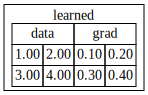

In [140]:
def nums_to_num_strs(arr: Iterable[NDArray]) -> Generator[str, None, None]:
  for elem in arr:
    yield '%.2f' % (elem,)

def num_strs_to_tds(arr: Iterable[str]) -> Generator[str, None, None]:
  for elem in arr:
    yield f'<td>{elem}</td>'

def row_strs_to_trs(arr: Iterable[str]) -> Generator[str, None, None]:
  for elem in arr:
    yield f'<tr>{elem}</tr>'

def ndarray_to_table(arr: NDArray, heading: str) -> str:
  as_2d = arr.reshape(-1, arr.shape[-1])
  tdata = ''.join((
    f'''<tr>
      <td colspan="{arr.shape[-1]}">{heading}</td>
    </tr>''',
    *row_strs_to_trs((tuple(num_strs_to_tds(nums_to_num_strs(row))) for row in as_2d)),
  ))
  return f'<table border="0" cellborder="1" cellspacing="0">{tdata}</table>'

def draw_table(root: BadTensor) -> Digraph:
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  uid = str(id('table'))
  # catted = concatenate([root.data, root.grad], axis=-1)
  # tdata = ''.join((
  #   f'<tr><td colspan="{root.data.shape[-1]}">data</td><td colspan="{root.grad.shape[-1]}">grad</td></tr>',
  #   *row_strs_to_trs((tuple(num_strs_to_tds(nums_to_num_strs(row))) for row in as_2d)),
  # ))
  data_tdata: str = ndarray_to_table(root.data, 'data')
  grad_tdata: str = ndarray_to_table(root.grad, 'grad')
  # table = '<<table border="0" cellborder="0" cellspacing="0"><tr><td>hey</td></tr></table>>'
  # table = f'<table border="0" cellborder="0" cellspacing="0">{tdata}</table>'
  supertable = f'''<table border="0" cellborder="0" cellspacing="0" cellpadding="0">
    <tr>
      <td cellspacing="0" cellpadding="0" colspan="2">{root.label}</td>
    </tr>
    <tr>
      <td cellspacing="0" cellpadding="0">{data_tdata}</td>
      <td cellspacing="0" cellpadding="0">{grad_tdata}</td>
    </tr>
  </table>'''
  
  dot.node(name=uid, shape='record', label=f'<{supertable}>')
  return dot
t = BadTensor(array([[1.,2], [3.,4]]), label='learned')
t.grad = array([[.1,.2], [.3,.4]])
draw_table(t)

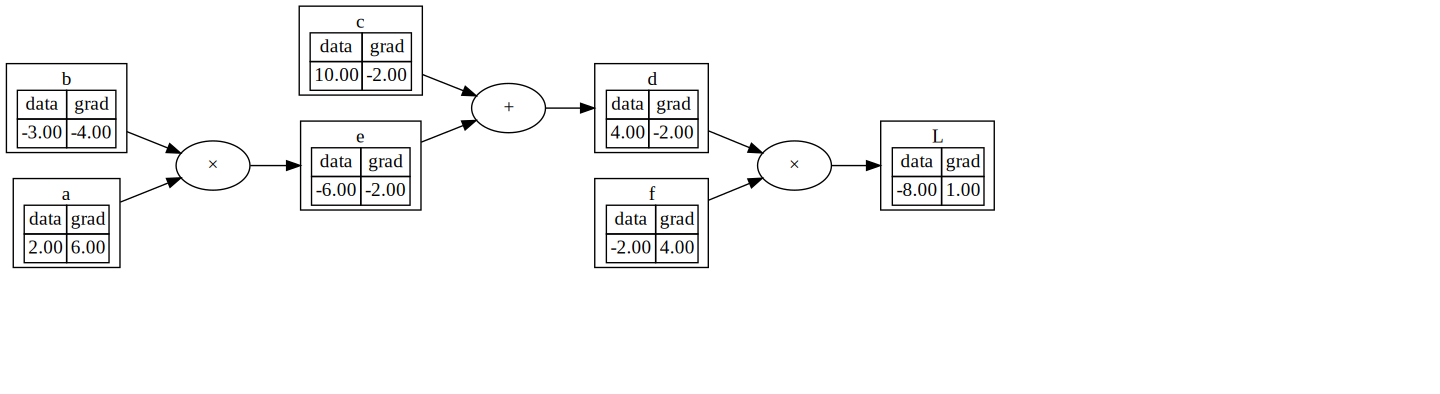

In [141]:
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot

def karpathy_basic() -> Digraph:
  a = BadTensor(r_[2.], label='a')
  b = BadTensor(r_[-3.], label='b')
  c = BadTensor(r_[10.], label='c')
  f = BadTensor(r_[-2.], label='f')
  e = (a * b).label_('e')
  d = (c + e).label_('d')
  L = (d * f).label_('L')
  L.backward()
  return draw_dot(L, graph_attr={**default_graph_attr, 'size': '20,20!', 'dpi': '50' })
karpathy_basic()

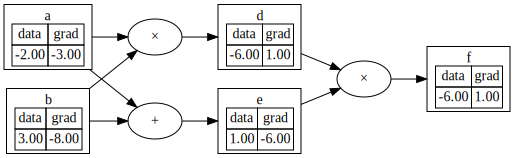

In [142]:
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot

def karpathy_crossed() -> Digraph:
  a = BadTensor(r_[-2.], label='a')
  b = BadTensor(r_[3.], label='b')
  d = (a * b).label_('d')
  e = (a + b).label_('e')
  f = (d * e).label_('f')
  f.backward()
  return draw_dot(f)
karpathy_crossed()

In [143]:
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot

def feet_inches_closure():
  class MiniBatch(NamedTuple):
    input: NDArray
    output: NDArray

  bs_slider = widgets.FloatLogSlider(value=1, min=0, step=1, max=4, base=2, readout_format='d', description='Batch size')
  bs_box = widgets.VBox([bs_slider], layout=widgets.Layout(border='solid', justify_content='center'))

  lr_coeff = widgets.IntSlider(value=1, min=1, step=1, max=9, readout_format='d', description='coeff')
  lr_exp = widgets.FloatLogSlider(value=1e-2, min=-5, step=1, max=-1, readout_format='.1g', description='mag')
  lr_box_title = widgets.Label(value='Learning rate:', layout=widgets.Layout(border_bottom='solid', justify_content='center'))
  lr_product = widgets.Label(layout=widgets.Layout(border_top='solid', justify_content='center'))
  lr_scaled_product = widgets.Label(layout=widgets.Layout(border_top='solid', justify_content='center'))
  def format_exp(f: float) -> str:
    return format(f, '.0e').replace('e-0', 'e-')
  def change_lr_product(change: Optional[Dict[str, Any]] = None):
    if change is None or change['type'] == 'change' and change['name'] == 'value':
      lr_product.value = format_exp(lr_coeff.value * lr_exp.value)
  def change_lr_scaled_product(change: Optional[Dict[str, Any]] = None):
    if change is None or change['type'] == 'change' and change['name'] == 'value':
      lr_scaled_product.value = 'scaled by batch size: %s' % (format_exp(lr_coeff.value * lr_exp.value * bs_slider.value),)
  change_lr_product()
  lr_coeff.observe(change_lr_product)
  lr_exp.observe(change_lr_product)
  change_lr_scaled_product()
  lr_coeff.observe(change_lr_scaled_product)
  lr_exp.observe(change_lr_scaled_product)
  bs_slider.observe(change_lr_scaled_product)

  lr_box = widgets.VBox([lr_box_title, lr_coeff, lr_exp, lr_product, lr_scaled_product], layout=widgets.Layout(border='solid'))

  step_slider = widgets.FloatLogSlider(value=1, min=0, step=1, max=10, base=2, readout_format='d', description='Step quantity')
  step_button = widgets.Button(layout=widgets.Layout(align_content='stretch'))
  def change_step_button(change: Optional[Dict[str, Any]] = None):
    if change is None or change['type'] == 'change' and change['name'] == 'value':
      step_button.description = f'Step {step_slider.value:0.0f} times'
  change_step_button()
  step_slider.observe(change_step_button)
  step_box = widgets.VBox([step_slider, step_button], layout=widgets.Layout(border='solid', justify_content='center', align_items='center'))

  reset_button = widgets.Button(description='Reset', layout=widgets.Layout(align_content='stretch'))
  reset_box = widgets.VBox([reset_button], layout=widgets.Layout(border='solid', justify_content='center'))

  controls = widgets.HBox([reset_box, lr_box, bs_box, step_box])

  graph_output = widgets.Output()

  display(controls, graph_output)

  def feet_inches_mat(lr: float, minibatch: MiniBatch) -> Generator[BadTensor, MiniBatch, None]:
    input, output = minibatch
    input_feet_inches = BadTensor(input, label='input_feet_inches')
    # should converge on [[2.54*12], [2.54]]
    learned_feet_inches_to_cm = BadTensor(atleast_2d([0., 0.]).T, label='learned_feet_inches_to_cm', train_me=True)
    expected_cm = BadTensor(output, label='true_cm')

    while True:
      predicted_cm = (input_feet_inches @ learned_feet_inches_to_cm).label_('predicted_cm')
      diff = (expected_cm - predicted_cm).label_('diff')
      L2 = (diff ** 2).label_('L2')

      sum = (L2.sum()).label_('sum')
      mse = (sum / L2.data.size).label_('MSE')

      mse.backward()
      minibatch: NDArray = yield mse

      trainable: List[BadTensor] = [t for t in mse.ancestors() if t.train_me]
      for t in trainable:
        t.data -= t.grad * lr

      input, output = minibatch
      input_feet_inches.data = input
      expected_cm.data = output
      
      for t in mse.ancestors():
        t.grad = zeros_like(t.data)

  target_weights: NDArray = array([[2.54*12], [2.54]])
  def make_minibatch(minibatch_size: int) -> MiniBatch:
    input: NDArray = rand(minibatch_size, 2) * array([10, 12])
    output: NDArray = input @ target_weights
    return MiniBatch(input=input, output=output)

  def make_gen(minibatch: MiniBatch) -> Generator[BadTensor, MiniBatch, None]:
    gen: Generator[BadTensor, NDArray, None] = feet_inches_mat(lr_coeff.value * lr_exp.value * minibatch.input.shape[0], minibatch)
    return gen

  def render(mse: BadTensor) -> Digraph:
    return draw_dot(mse, graph_attr={**default_graph_attr, 'size': '40,40!', 'dpi': '72' })

  def update_graph_output(dot: Digraph) -> None:
    with graph_output:
      clear_output()
      display_svg(dot)

  def step(gen: Generator[BadTensor, MiniBatch, None], step_count: int) -> BadTensor:
    for _ in range(step_count):
      minibatch: MiniBatch = make_minibatch(int(bs_slider.value))
      loss: BadTensor = gen.send(minibatch)
    return loss

  def reset(_=None) -> Generator[BadTensor, MiniBatch, None]:
    minibatch: MiniBatch = make_minibatch(int(bs_slider.value))
    gen = make_gen(minibatch)
    loss: BadTensor = next(gen)
    # loss: BadTensor = step(gen, 1)
    dot: Digraph = render(loss)
    update_graph_output(dot)
    return gen
  reset_button.on_click(reset)
  
  gen: Generator[BadTensor, MiniBatch, None] = reset()

  def on_step_button(_=None) -> None:
    loss: BadTensor = step(gen, int(step_slider.value))
    dot: Digraph = render(loss)
    update_graph_output(dot)
  step_button.on_click(on_step_button)
  
feet_inches_closure()

Output()